# Comparison between LSTMs and AttentionLSTMs


In [1]:
import numpy as np
import os, logging
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
logging.getLogger("tensorflow").setLevel(logging.CRITICAL)
logging.getLogger("tensorflow_hub").setLevel(logging.CRITICAL)
import keras as K

time_series = np.sin(np.linspace(1, 10*np.pi, 1000))

Using TensorFlow backend.


In [2]:
# Construct training set via sliding window

lag = 10
x = []
y = []

for i in range(len(time_series) - lag):
    x.append(time_series[i:i+lag])
    y.append(time_series[i+lag])

# batch, dimension, lag
x_train = np.array(x).reshape(-1, lag, 1)
y_train = np.array(y).reshape(-1, 1)

In [3]:
# Build ATT_LSTM model
input_layer = K.layers.Input(shape=(x_train.shape[1], x_train.shape[2]), dtype='float32') 
x = K.layers.LSTM(30, return_sequences=True)(input_layer)
attention_pre = K.layers.Dense(1, name='attention_vec')(x)   
attention_probs = K.layers.Softmax()(attention_pre)  
attention_mul = K.layers.Lambda(lambda x:x[0]*x[1])([attention_probs,x])
x = K.layers.Flatten()(attention_mul)
x = K.layers.Dense(20, activation='relu')(x)
preds = K.layers.Dense(1, activation='linear')(x)
model1 = K.models.Model(input_layer, preds)
model1.compile(loss='mse', optimizer=K.optimizers.Adam(0.01),metrics=['mse'])

# Build LSTM model
input_layer = K.layers.Input(shape=(x_train.shape[1], x_train.shape[2]), dtype='float32') 
x1 = K.layers.LSTM(30, return_sequences=True)(input_layer)
x2 = K.layers.LSTM(30, return_sequences=False)(x1)
x3 = K.layers.Dense(1)(x2)
model2 = K.models.Model(input_layer, x3)
model2.compile(loss='mse', optimizer=K.optimizers.Adam(0.01),metrics=['mse'])

In [4]:
batch_size = 1
epochs = 50

model1.fit(x_train, y_train, batch_size=batch_size, epochs = epochs)
model2.fit(x_train, y_train, batch_size=batch_size, epochs = epochs)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Epoch 1/50





990/990 [==============================] - 4s 4ms/step - loss: 0.0115 - mean_squared_error: 0.0115
Epoch 2/50
990/990 [==============================] - 3s 3ms/step - loss: 0.0028 - mean_squared_error: 0.0028
Epoch 3/50
990/990 [==============================] - 3s 3ms/step - loss: 0.0193 - mean_squared_error: 0.0193
Epoch 4/50
990/990 [==============================] - 3s 3ms/step - loss: 0.0015 - mean_squared_error: 0.0015
Epoch 5/50
990/990 [==============================] - 3s 3ms/step - loss: 8.2913e-04 - mean_squared_error: 8.2913e-04
Epoch 6/50
990/990 [==============================] - 3s 3ms/step - loss: 0.0018 - mean_squared_error: 0.0018
Epoch 7/50
990/990 [==============================] - 3s 3ms/step - loss: 0.0020 - mean_squared_error: 0.0020
Epoch 8/50
990/990 [==============================] - 3s 3ms/step - loss: 0.0013 - mean_squared_error: 0.0013
Epoch 9/50

990/990 [==============================] - 5s 5ms/step - loss: 0.0068 - mean_squared_error: 0.0068
Epoch 5/50
990/990 [==============================] - 5s 5ms/step - loss: 5.2020e-04 - mean_squared_error: 5.2020e-04
Epoch 6/50
990/990 [==============================] - 5s 5ms/step - loss: 0.0015 - mean_squared_error: 0.0015
Epoch 7/50
990/990 [==============================] - 5s 5ms/step - loss: 8.1626e-04 - mean_squared_error: 8.1626e-04
Epoch 8/50
990/990 [==============================] - 5s 5ms/step - loss: 9.2114e-04 - mean_squared_error: 9.2114e-04
Epoch 9/50
990/990 [==============================] - 5s 6ms/step - loss: 5.9422e-04 - mean_squared_error: 5.9422e-04
Epoch 10/50
990/990 [==============================] - 5s 5ms/step - loss: 8.7388e-04 - mean_squared_error: 8.7388e-04
Epoch 11/50
990/990 [==============================] - 5s 5ms/step - loss: 3.7653e-04 - mean_squared_error: 3.7653e-04
Epoch 12/50
990/990 [==============================] - 5s 5ms/step - loss: 5.3062

In [6]:
import copy

time_series1 = copy.deepcopy(time_series)
time_series2 = copy.deepcopy(time_series)

for i in range(200):
    # model1
    inp = time_series1[-lag:].reshape(-1, lag, 1)
    time_series1 = np.hstack([time_series1, model1.predict(inp)[0]])
    
    # model2
    inp = time_series2[-lag:].reshape(-1, lag, 1)
    time_series2 = np.hstack([time_series2, model2.predict(inp)[0]])

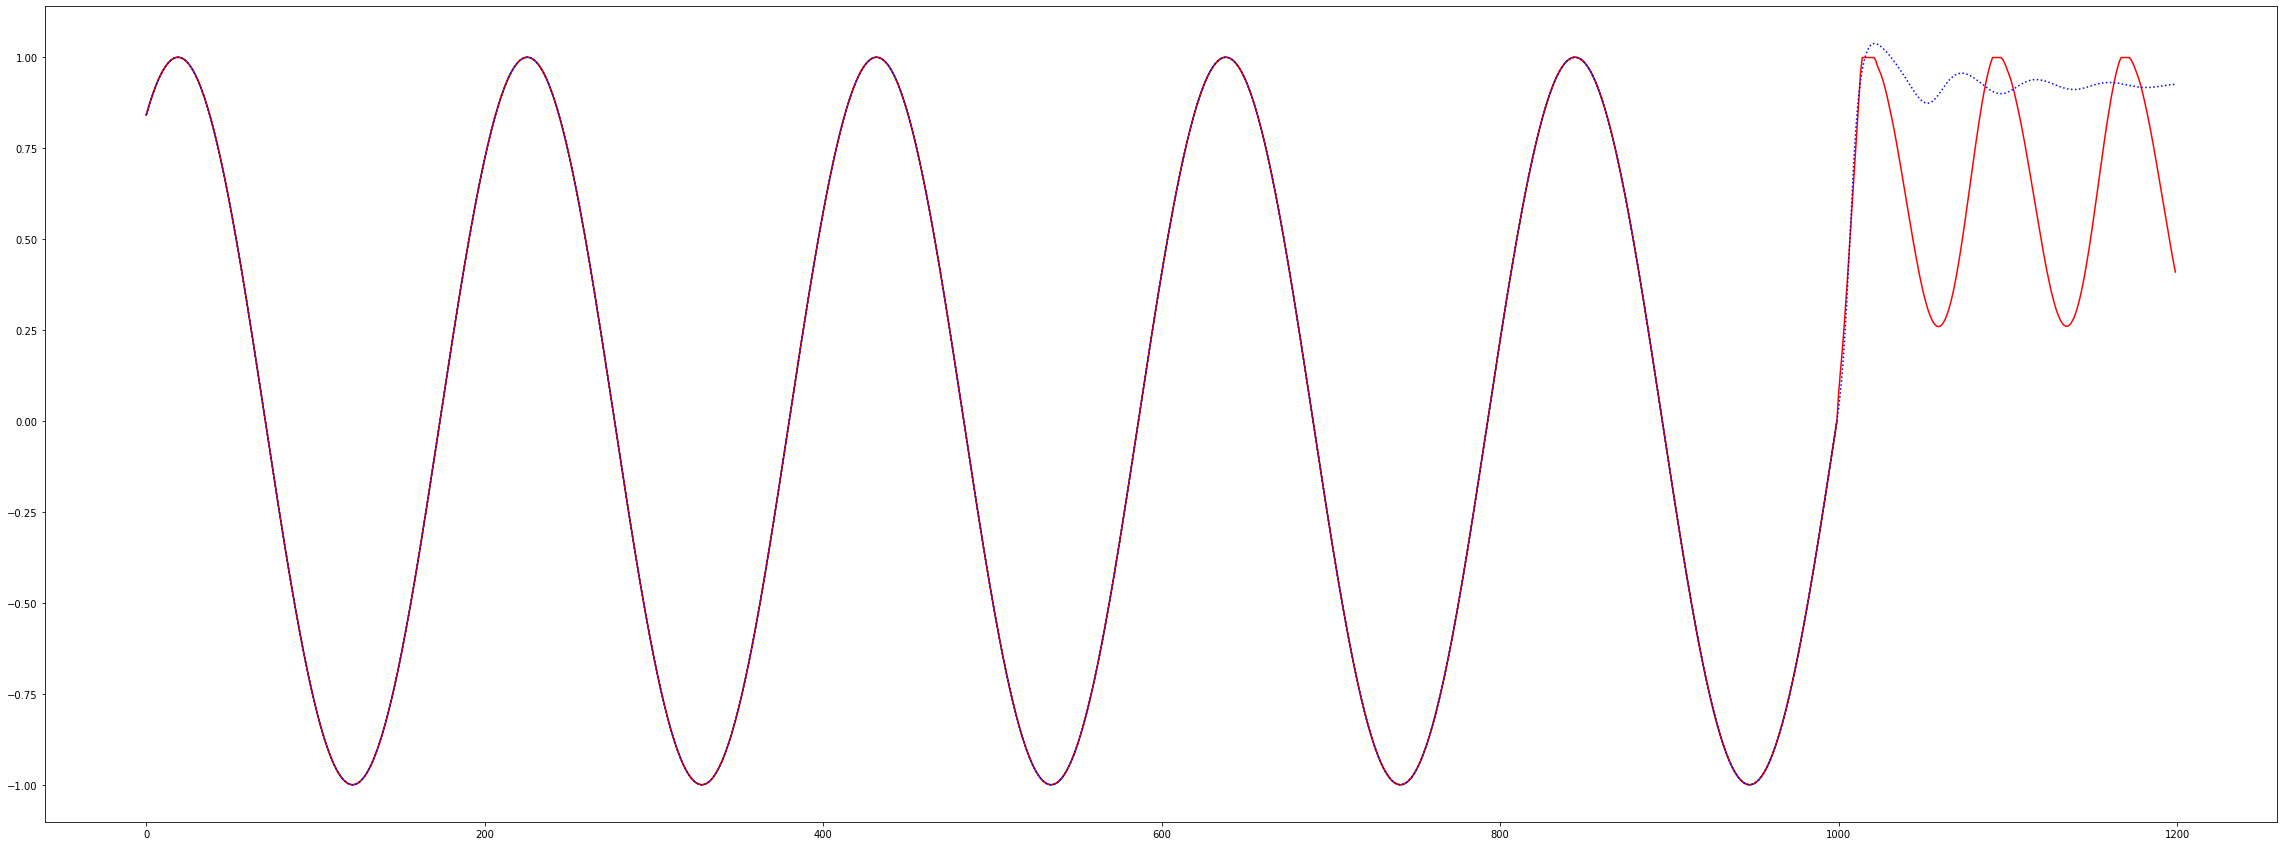

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline 

plt.figure(figsize=(40,15))   
plt.plot(time_series, color='black', label='Training')
plt.plot(time_series1, 'r-', label='ATT_LSTM')
plt.plot(time_series2, 'b:', label='LSTM')